*************************************************************

Loading Abaqus-mesh from C:\NDCSI\framework\data\abaqus_files\simple_sector\abaqus.inp
Can not read the given string list
WARNING 3D case were selected
Mesh C:\NDCSI\framework\data\abaqus_files\simple_sector\abaqus.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


<IPython.core.display.Javascript object>


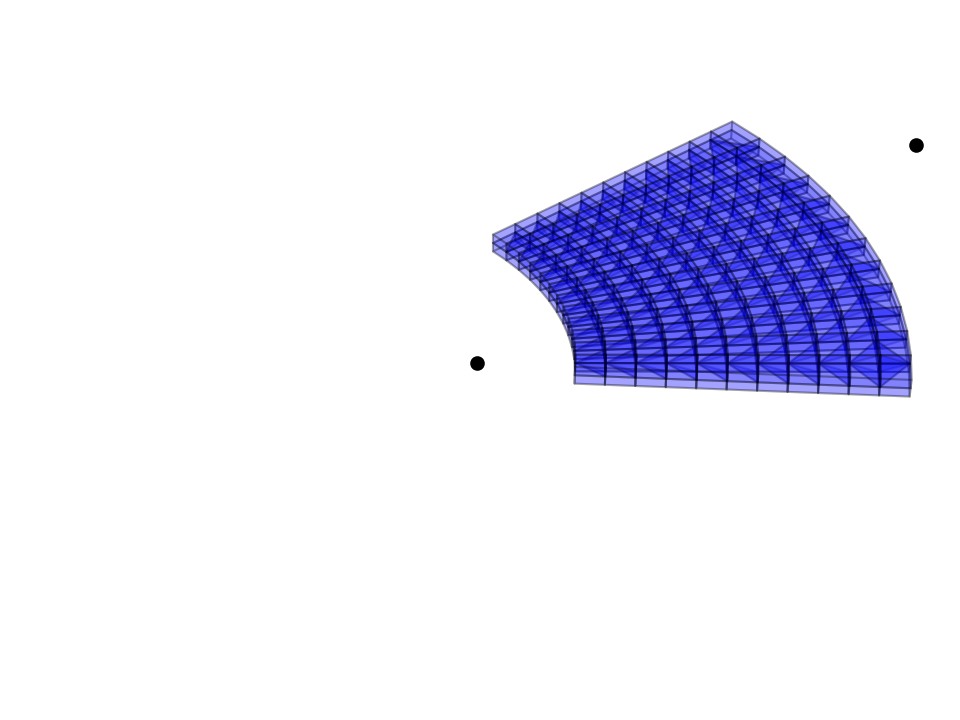

Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.


(-0.70710676, 14.849241959999999, -0.70710676, 14.849241959999999)

In [48]:
# importing lib and setting a list of meshes to be tested

import sys 
import amfe
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook


# making the path relative to the project
local_folder = os.getcwd()[:]
os.chdir('..')
project_folder = os.getcwd()[:]
os.chdir(local_folder)
sys.path.append(r'project_folder')

mesh_inp = os.path.join(project_folder,r'data\abaqus_files\simple_sector\abaqus.inp')


m = amfe.Mesh()
m.import_inp(mesh_inp,1.0)

m.split_in_groups()

g = m.groups.keys()

sub_domain = m.groups['SOLID_1_1_SOLID_ELSET']

sub_domain.create_elem_dict()


vertice_matrix = sub_domain.get_element(0)
points_coord = sub_domain.parent_mesh.nodes

ax = amfe.plot3Dmesh(m, ax=None, boundaries=True, alpha=0.2, color='blue', scale = 1000, plot_nodes=False)
ax.view_init(-90, 0)
#ax.set_aspect('equal', adjustable='box')
xlim = ax.get_xlim()
ax.set_ylim(xlim)
ax.set_zlim(xlim)
plt.axis('off')


In [5]:
print('Physical Groups')
print(g)

Physical Groups
dict_keys(['SOLID_1_1_SOLID_ELSET', 'LOW_ELSET', 'HIGH_ELSET', 'DIRICHLET_ELSET', 'SOLID_1_1_ELSET'])


In [3]:
my_comp = amfe.CraigBamptonComponent()
my_comp.set_mesh_obj(m)

my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain('SOLID_1_1_SOLID_ELSET',my_material)

K, f = my_comp.assembly_class.assemble_k_and_f()
K_, f = my_comp.assembly_class.assemble_k_and_f_neumann()
M = my_comp.assembly_class.assemble_m()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 264 elements and 4923 dofs.
Time taken for preallocation: 0.07 seconds.


In [9]:
dirsub = m.get_submesh('phys_group', 'DIRICHLET_ELSET')
cyclic_low = m.get_submesh('phys_group', 'LOW_ELSET')
cyclic_high = m.get_submesh('phys_group', 'HIGH_ELSET')

id_matrix = my_comp.assembly_class.id_matrix
dir_dofs = amfe.get_dirichlet_dofs(dirsub, direction ='xyz', id_matrix=id_matrix)
low_dofs = amfe.get_dirichlet_dofs(cyclic_low, direction ='xyz', id_matrix=id_matrix)
high_dofs = amfe.get_dirichlet_dofs(cyclic_high, direction ='xyz', id_matrix=id_matrix)


# remove Dirichle dofs at cyclic dofs 
dir_dofs = list(set(dir_dofs).difference(low_dofs))
dir_dofs = list(set(dir_dofs).difference(high_dofs))

In [20]:
nodes_low = m.node_sets_dict['LOW_NSET']
nodes_high = m.node_sets_dict['HIGH_NSET']
nodes_dir = m.node_sets_dict['DIRICHLET_NSET']
print('Number of nodes in Lower region %i' %len(nodes_low))
print('Number of nodes in Higher region %i' %len(nodes_high))
print('Number of nodes in Dirichlet region %i' %len(nodes_dir))

Number of nodes in Lower region 88
Number of nodes in Higher region 88
Number of nodes in Dirichlet region 95


In [22]:
# inserting dirichlet boundary contitions
K, M, f = my_comp.insert_dirichlet_boundary_cond(K,M,f,dir_dofs)

# removing dirichlet B.C in order to use sparse eigen solver 
Kii, S, S_inv, T, fi = my_comp.create_selection_operator(dir_dofs, K, f, remove = True)
Mii, Sm, Sm_inv, Tm = my_comp.create_selection_operator(dir_dofs, M, remove = True)

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


returning reduced right side, please umpack 5 elementes


In [24]:
from scipy.sparse import linalg as splinalg

num_of_modes = 10
omega, V_dynamic = splinalg.eigs(Kii, k=num_of_modes, M = Mii, which='SM')

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


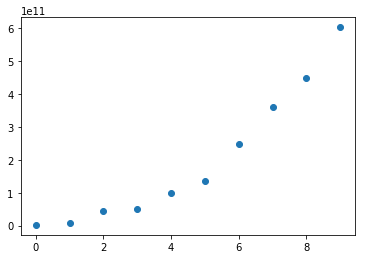

In [26]:
plt.plot(omega,'o')

In [60]:
V_dynamic = np.real(V_dynamic)
mode_shape = []
for i in range(num_of_modes):
    mode_shape.append(T(V_dynamic[:,i]))
    
def get_mode(mode_number):
    return mode_shape[mode_number]

def set_CG_comp(mode_number):
    u = get_mode(mode_number)
    my_comp.mesh_class.nodes = my_comp.mesh_class.nodes*1.0
    my_comp.u_output = []
    my_comp.u_output.append(0.0*u)
    my_comp.u_output.append(0*u)
    return my_comp

In [61]:
%matplotlib notebook
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(scale=(-4,4,0.5),mode=(0,10,1)) 
def plot(mode=0,scale=0.0):
    my_comp = set_CG_comp(mode)
    #fig, ax1 = plt.subplots(1, figsize=(20,10), dpi=80)
    ax = amfe.plot_3D_displacement(my_comp) 
    ax.view_init(-90, 0)
    xlim = ax.get_xlim()
    ax.set_ylim(xlim)
    ax.set_zlim(xlim)
    plt.axis('off')
    plt.show()


interactive(children=(IntSlider(value=0, description='mode', max=10), FloatSlider(value=0.0, description='scal…